# EM algorithm mixture model and LDA estimation

This notebook aims to investigate differences in word frequency distributions between 2 different classes of documents relating to terror and tourism. The classes are generated using 2 different methods - EM algorithm and LDA

# Import packages

In [ ]:
import pandas as pd
import numpy as np
import string
import csv
import nltk
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
import os
import numpy as np
from scipy.special import logsumexp
from collections import Counter
import gensim
from gensim import models
from gensim import corpora
from collections import defaultdict


new_stopwords = set(stopwords.words('english'))
lmtzr = WordNetLemmatizer()

# Load data

This notebook is based on news coverage data used by an ongoing research project- hence the data is not available. 
#Besley, Fetzer and Mueller (2020) "Terror and Tourism: The Economic Consequences of Media Coverage".

In [ ]:
# os.environ["PATH"] += os.pathsep + 'C:\\Program Files (x86)\\Graphviz2.38\\bin'

## Set path
# path='C:\\Users\\hanne\\Dropbox\\teaching\\Data Science Text Mining 2020\\programs\\lecture 1'

# Load data
#this is loading a dataset of news items on chinese news on Turkey
filename ="100articles.csv"

# corpus_data = pd.read_csv(os.path.join(path, filename), sep=',', encoding='utf-8')
corpus_data = pd.read_csv(filename)

corpus_data.info()

# Pre-processing and data exploration

In [1]:
# pre-process the text of titles, doing normalization, excluding stop-words
corpus_data['titles_lemm'] = ""
for ind,line in corpus_data.iterrows():
    tit = corpus_data.TITLE_EN.iloc[ind]
    tit_tok = nltk.word_tokenize(tit)
    tit_lem = []
    for tok in tit_tok:
        tit_lem.append(lmtzr.lemmatize(tok.lower()))
    tit_filter = [word for word in tit_lem if word not in new_stopwords]
    tit_filter_dop = [word for word in tit_filter if word not in '.,:;-?']
    tit_string = ' '.join(tit_filter_dop)
    if tit_string == ' ':
        corpus_data.at[ind, 'titles_lemm']='---'
    else:
        corpus_data.at[ind, 'titles_lemm']=tit_string
        
print("done with titles")

# pre-process the text of titles plus article bodies, doing normalization, excluding stop-words
corpus_data['text_with_head_lemm'] = ""
for ind,line in corpus_data.iterrows():
    tit = corpus_data.TITLE_EN.iloc[ind] + corpus_data.TXT_EN.iloc[ind]
    tit_tok = nltk.word_tokenize(tit)
    tit_lem = []
    for tok in tit_tok:
        tit_lem.append(lmtzr.lemmatize(tok.lower()))
    tit_filter = [word for word in tit_lem if word not in new_stopwords]
    tit_filter_dop = [word for word in tit_filter if word not in '.,:;-?']
    tit_filter_dop = [word for word in tit_filter_dop if word not in "'s"]
    tit_string = ' '.join(tit_filter_dop)
    if tit_string == ' ':
        corpus_data.at[ind,'text_with_head_lemm']='---'
    else:
        corpus_data.at[ind,'text_with_head_lemm']=tit_string

print("done with text plus titles")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 13 columns):
ARTICLENUMID     108 non-null object
LENGTH           108 non-null object
year             108 non-null int64
day              108 non-null int64
monthnum         108 non-null int64
issuing_iso3c    108 non-null object
dest_iso3c       108 non-null object
TXT_EN           108 non-null object
label_0          97 non-null float64
label_1          97 non-null float64
label_2          97 non-null float64
label_3          97 non-null float64
TITLE_EN         108 non-null object
dtypes: float64(4), int64(3), object(6)
memory usage: 11.1+ KB
done with titles
done with text plus titles


In [4]:
# Before preprocessing
print(corpus_data.TXT_EN[:])

0      News Analysis: Assassination of Russian envoy ...
1      Sisi voices to Putin Egypt's solidarity with R...
2      EU eyes expanding trade ties with Turkey by mo...
3      Turkey's president says Russian envoy's assass...
4      Laos extends condolences over tragic events in...
                             ...                        
103    Urgent: UN chief slams deadly terrorist attack...
104    Turkish ruling party submits constitutional am...
105    Since the beginning of the Syrian crisis, Anka...
106    A total of 16 civil servants from the new Iraq...
107    Turkey issues detention warrants for 87 schola...
Name: TXT_EN, Length: 108, dtype: object


In [5]:
# After preprocessing
print(corpus_data.text_with_head_lemm[:10])

0    news analysis assassination russian envoy coul...
1    sisi voice putin egypt solidarity russia terro...
2    eu eye expanding trade tie turkey modernizing ...
3    turkey president say russian envoy assassin wa...
4    lao extends condolence tragic event germany tu...
5    india condemns russian envoy assassination tur...
6    slain russian ambassador body arrives moscowa ...
7    turkey say gulenist behind russian envoy murde...
8    turkey hold ceremony assassinated russian envo...
9    sudan condemns assassination russian ambassado...
Name: text_with_head_lemm, dtype: object


In [2]:
# Convert to dataframes, titles and texts
Titles = corpus_data.titles_lemm.tolist()
Texts = corpus_data.text_with_head_lemm.tolist()

# Convert to document-term matrix with single words as untis.
cv = CountVectorizer(ngram_range = (1,1))
cv.fit(Texts)
vectorized_text=cv.transform(Texts)

# Make dense matrix from sparse matrix
vectorized_text=vectorized_text.todense()
vectorized_text.shape

(108, 2526)

Text(0, 0.5, 'count')

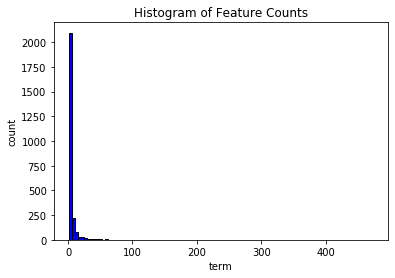

In [3]:
# Explore word frequencies

sumcolumn=vectorized_text.sum(axis=0)

plt.hist(sumcolumn.T, color = 'blue', edgecolor = 'black', bins=100)

plt.title('Histogram of Feature Counts')
plt.xlabel('term')
plt.ylabel('count')

# EM algorithm

In [7]:
def _multi_mle(X, w):
    X = X * w[:, np.newaxis]
    return X.sum(axis=0) / X.sum()

def _multi_ll(X, params):
    return X @ np.log(params).T

def m_step(X, r):
    _, K = r.shape
    _, P = X.shape

    new_params = np.zeros((K, P))
    for i in np.arange(K):
        new_params[i, :] = _multi_mle(X, r[:, i])

    priors = r.sum(axis=0) / r.sum()
    return priors, new_params


def e_step(X, params, priors):
''' whatchout for numerical stability here! use logs to avoid underflow and/or put an epsilon floor'''

    loglik = _multi_ll(X, params)

    # Sum across axis 1 to get prob per observation, then sum logs to get total probability
    total_ll = np.sum(logsumexp(loglik, axis=1))

    joint = loglik + np.log(priors)
    marginal = logsumexp(joint, axis=1)
    probs = joint - marginal[:, np.newaxis]
    probs = np.exp(probs)

    return probs, total_ll

def em_algo(X, priors, max_iter=100, tol=0.5):
    X = np.array(X)

    # add epsilon count to each feature to avoid zero probabilities for any feature in any class
    X = X+1e-7

    K, = priors.shape
    _, P = X.shape
    
    #random initialization
    params = np.random.uniform(0, 1, (K, P))
    params /= params.sum(1)[:, np.newaxis]

    loglik = 0
    for _ in range(max_iter):
        r, loglik_ = e_step(X, params, priors)
        priors, params = m_step(X, r)
        if np.abs(loglik - loglik_) < tol:
            break
        loglik = loglik_

    return r, params

In [9]:
# Set prior
prior= np.array([0.5, 0.5])
vectorized_text=np.array(vectorized_text)

#here I am calling nandan's code
classes, betas=em_algo(vectorized_text, prior)

# Print output
print(np.round(classes[:,0], 2))

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0.
 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0.]


In [11]:
# What classes have been created by the EM algorithm?

class1=np.round(classes[:,0], 2)
ids1 = np.where(class1==1)[0]
for textid in ids1:
    print(textid)
    print(Titles[textid])

2
eu eye expanding trade tie turkey modernizing custom union
13
russia turkey iran launch joint effort revive political process syria
15
turkey open first undersea tunnel linking istanbul 's asian european part
16
spotlight envoy murder may strengthen russia-turkey-iran anti-terror cooperation russian expert
20
russia sends task force turkey probe ambassador 's murder
25
sri lanka strongly condemns assassination russia 's ambassador turkey
26
chinese fm sends message condolence russia assassination ambassador
47
1st ld russia confirms ambassador turkey attacked gunman
48
urgent russia confirms ambassador turkey attacked gunman
50
isesco condemns bombing attack turkey
53
thousand protest pkk terror attack turkey
55
117 wounded aleppians transferred turkish hospital
60
iran turkey russia fm meet moscow syria spokesman
62
injury reported explosion near university campus southern turkey
64
rebel ' failure fulfill deal cause suspension aleppo evacuation source
65
austria still & quot open d

In [12]:
ids0 = np.where(class1==0)[0]
for textid in ids0:
    print(textid)
    print(Titles[textid])

0
news analysis assassination russian envoy could accelerate rapprochement russia turkey
1
sisi voice putin egypt 's solidarity russia terrorism
3
turkey 's president say russian envoy 's assassin wa gulenist
4
lao extends condolence tragic event germany turkey
5
india condemns russian envoy 's assassination turkey
6
slain russian ambassador 's body arrives moscow
7
turkey say gulenist behind russian envoy 's murder
8
turkey hold ceremony assassinated russian envoy
9
sudan condemns assassination russian ambassador turkey
10
kurdistan militant group claim attack central turkey
11
news analysis assassination russian ambassador damage russia-turkey tie
12
syrian refugee family returned turkey eu-turkey deal
14
bih tightens security around embassy sarajevo
17
russian embassy baku tightens security assassination envoy turkey
18
turkey vow continued cooperation russia syria envoy slaying
19
russian delegation ankara probe assassination ambassador
21
roundup int ' l community condemns assassi

In [13]:
# A different kind of summary
topind = np.argsort(betas)

# list out keys and values separately 
key_list = list(cv.vocabulary_.keys()) 
val_list = list(cv.vocabulary_.values()) 
print("top terms in first class")
for term in topind[0,:5]:
    print(key_list[val_list.index(term)]) 
print("")
print("top terms in second class")
for term in topind[1,:5]:
    print(key_list[val_list.index(term)]) 

top terms in first class
zurich
route
ruining
gaza
gathering

top terms in second class
speed
bombings
equipped
turkeysri
es


In [23]:
df = pd.DataFrame(np.zeros([500, 4]))
vectorized_text = pd.DataFrame(vectorized_text)
Y1 = [i in ids1 for i in range(0,len(classes))]
Y0 = [i in ids0 for i in range(0,len(classes))]

i = 0
for term in [1449, 1608, 2004, 2110, 1914, 1906, 256, 2345, 2313,  245, 1444, 1247, 2193, 1689, 950, 2233, 2192, 1619, 1042,
            608, 1905, 256, 1215, 2313, 2233, 2192, 199, 1444, 1042, 2443, 2330 ]:#Counter(vectorized_text.iloc[Y0, :].sum(axis= 0).sort_values()[-5:].index):
    
    
    zero_counts = Counter(vectorized_text.iloc[Y0, term])
    print(zero_counts)
    
    for key, value in zero_counts.items():
        
        df.iloc[i, 0] = key_list[val_list.index(term)]
        df.iloc[i, 1] = 0
        df.iloc[i, 2] = key
        df.iloc[i, 3] = value
        i+=1
        
    one_counts = Counter(vectorized_text.iloc[Y1, term])
    print(one_counts)
    
    for key, value in one_counts.items():
        
        df.iloc[i, 0] = key_list[val_list.index(term)]
        df.iloc[i, 1] = 1
        df.iloc[i, 2] = key
        df.iloc[i, 3] = value     
        i +=1
    
    
# for term in Counter(vectorized_text.iloc[Y1, :].sum(axis= 0).sort_values()[-5:].index):
    
    
#     zero_counts =  Counter(vectorized_text.iloc[Y0, term])
#     print(zero_counts)
    
#     for key, value in zero_counts.items():
        
#         df.iloc[i, 0] = key_list[val_list.index(term)]
#         df.iloc[i, 1] = 0
#         df.iloc[i, 2] = key
#         df.iloc[i, 3] = value
#         i+=1
        
#     one_counts = Counter(vectorized_text.iloc[Y0, term])
#     print(one_counts)
    
#     for key, value in one_counts.items():
        
#         df.iloc[i, 0] = key_list[val_list.index(term)]
#         df.iloc[i, 1] = 1
#         df.iloc[i, 2] = key
#         df.iloc[i, 3] = value     
#         i +=1

Counter({0: 51, 1: 11, 2: 6, 5: 1, 7: 1, 3: 1, 4: 1})
Counter({0: 31, 1: 3, 3: 1, 4: 1})
Counter({0: 63, 1: 5, 2: 3, 5: 1})
Counter({0: 31, 2: 3, 1: 2})
Counter({0: 46, 1: 16, 2: 5, 3: 3, 4: 2})
Counter({0: 34, 1: 2})
Counter({0: 55, 1: 12, 3: 2, 2: 1, 4: 1, 6: 1})
Counter({0: 28, 1: 7, 2: 1})
Counter({0: 27, 1: 16, 2: 12, 3: 8, 5: 4, 6: 2, 7: 1, 9: 1, 4: 1})
Counter({0: 18, 1: 10, 2: 7, 5: 1})
Counter({0: 33, 4: 10, 3: 8, 5: 6, 6: 5, 2: 3, 8: 2, 9: 2, 7: 1, 15: 1, 1: 1})
Counter({0: 28, 2: 5, 1: 2, 6: 1})
Counter({0: 27, 1: 13, 3: 7, 2: 7, 5: 6, 4: 6, 6: 3, 8: 1, 10: 1, 15: 1})
Counter({0: 21, 1: 4, 4: 3, 2: 3, 5: 2, 3: 2, 6: 1})
Counter({0: 21, 2: 17, 1: 10, 3: 7, 5: 5, 6: 4, 9: 3, 4: 3, 7: 1, 22: 1})
Counter({0: 11, 2: 10, 1: 7, 3: 3, 6: 2, 5: 1, 4: 1, 7: 1})
Counter({3: 19, 1: 15, 2: 11, 4: 7, 5: 5, 9: 3, 6: 2, 20: 2, 7: 2, 14: 2, 19: 1, 11: 1, 10: 1, 35: 1})
Counter({3: 13, 2: 8, 1: 5, 5: 4, 12: 2, 4: 2, 8: 1, 11: 1})
Counter({0: 52, 3: 8, 4: 5, 1: 3, 2: 2, 7: 1, 6: 1})
Counter({0

In [244]:
# df = df.iloc[0:154,]
df.columns = ['words', 'classn', 'tf', 'numdocs']
df.iloc[150:154, ]

,0,1,2,3
150,0,0.0,0.0,0.0
151,0,0.0,0.0,0.0
152,0,0.0,0.0,0.0
153,0,0.0,0.0,0.0


# Visualise differences in word frequency distributions between our 2 classes

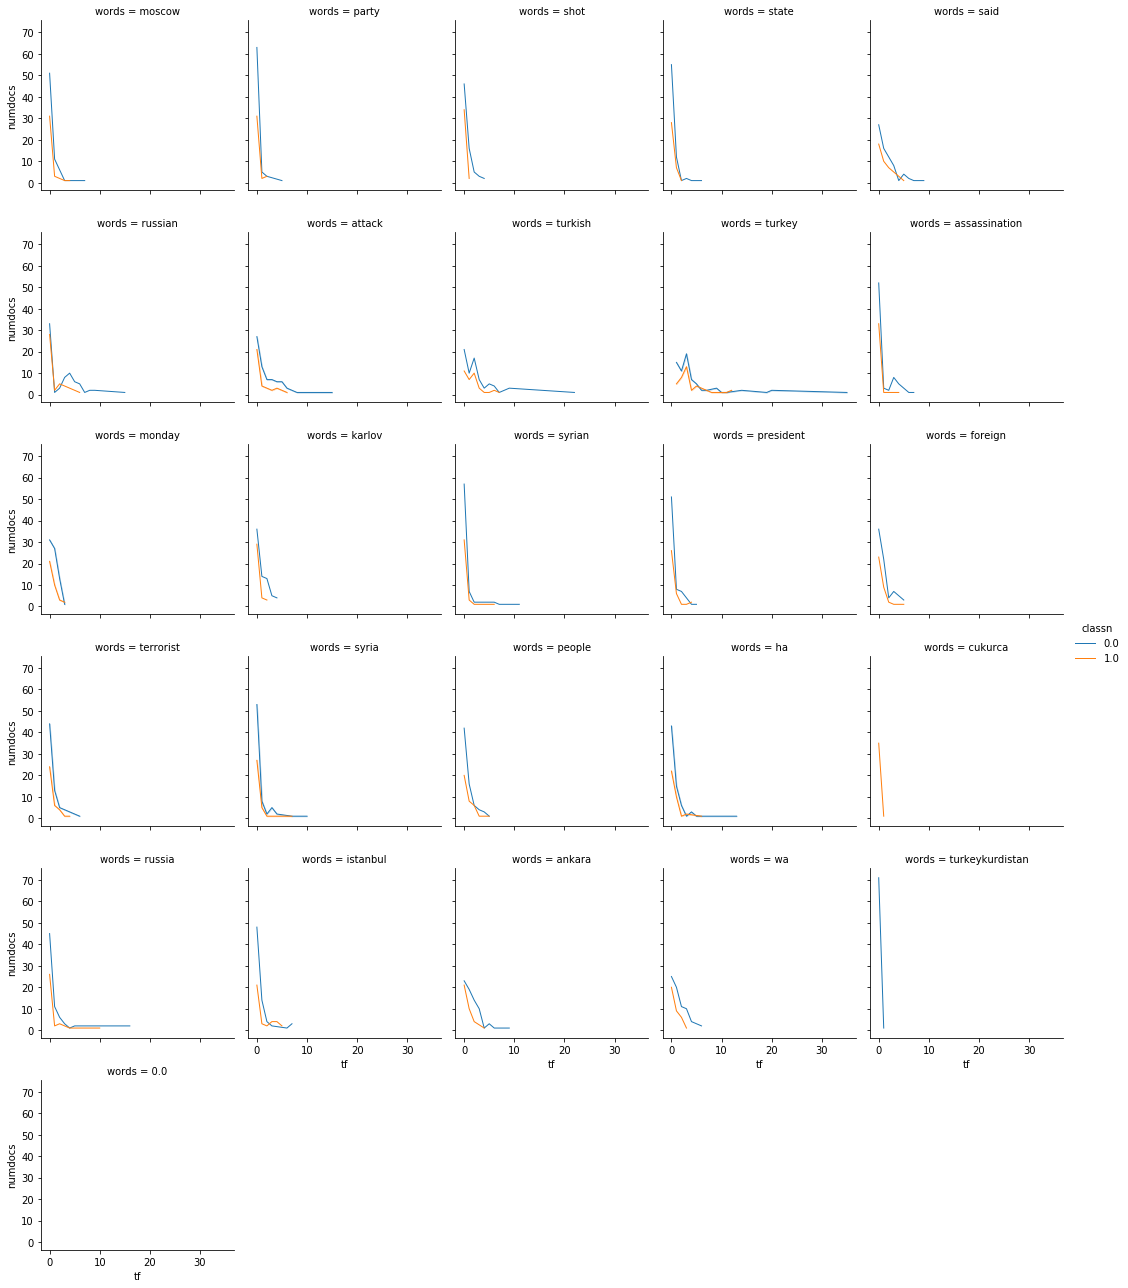

In [25]:
kws = dict(linewidth=1)

def qqplot(x, y, **kwargs):
    sns.lineplot(x, y, **kwargs)
    
   
g = sns.FacetGrid(df, col="words", hue="classn", col_wrap=5)
g = (g.map(qqplot, "tf", "numdocs", **kws)
    .add_legend())

# LDA

LDA model: https://en.wikipedia.org/wiki/Dirichlet_distribution#/media/File:LogDirichletDensity-alpha_0.3_to_alpha_2.0.gif

In [ ]:
# Preprocessing

texts = [
    [word for word in document.split()]
    for document in Texts
]

frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [
    [token for token in text if frequency[token] > 1]
    for text in texts
]

#pprint(texts)

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
#Estimate LDA model with two topics
lda=models.LdaModel(corpus, id2word=dictionary, num_topics=2)

lda.print_topics(2)

In [ ]:
get_document_topics = [lda.get_document_topics(item, minimum_probability=0.0000001) for item in corpus]

# Results in tuples
print(get_document_topics[0:10])

In [ ]:
#getting only the topic shares out of the tuples
topic1share=[x[0][1] for x in get_document_topics]
topic2share=[x[1][1] for x in get_document_topics]

In [ ]:
# Show clustering
plt.scatter(topic1share,topic2share, color='r')
plt.xlabel('topic share 1')
plt.ylabel('topic share 2')
plt.show()